In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
#from pathlib import Path
import sys
import os
import argparse
# sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
sys.path.append('../')
import json
from pathlib import Path
from log import logger
import logging
#from lib.io.loadConfigs import *
import lib.io.loadConfigs as loadConfigs
import lib.io.readPollyRawData as readPollyRawData
import lib.interface.picassoProc as picassoProc
import lib.misc.helper as helper
import lib.misc.startscreen as startscreen
import lib.misc.json2nc_mapping as json2nc_mapping

In [30]:
## getting root dir of PicassoPy
root_dir0 = Path(os.path.abspath('')).resolve().parent
root_dir = helper.detect_path_type(root_dir0)

print(root_dir0)
print(root_dir)

## setting config files
picasso_default_config_file = Path(root_dir,'lib','config','pollynet_processing_chain_config.json')
print(picasso_default_config_file)
polly_default_config_file = Path(root_dir,'lib','config','polly_global_config.json')
print(polly_default_config_file)
#picasso_config_file = "/pollyhome/Bildermacher2/experimental/PicassoPy/config/pollynet_processing_chain_config_rsd2_24h_exp.json"



/mnt/c/Users/radenz/dev/PicassoPy/PicassoPy
/mnt/c/Users/radenz/dev/PicassoPy/PicassoPy
/mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/pollynet_processing_chain_config.json
/mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/polly_global_config.json


In [4]:
# for purpose of the notebook mimic the argparse interface
from types import SimpleNamespace
args = SimpleNamespace()

args.timestamp = '20230618'
args.device = 'arielle'

args.picasso_config_file = "/mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/pollynet_processing_chain_config_interface.json"
args.level0_file_to_process = "../../../../localdata/coala/arielle_24h/2023_06_18_Sun_ARI_00_00_01.nc"

In [5]:
import pprint

In [6]:
## start_screen
startscreen.startscreen()

## loading configs as dicts
picasso_config_dict = loadConfigs.loadPicassoConfig(args.picasso_config_file,picasso_default_config_file)
pprint.pprint(picasso_config_dict)
polly_config_array = loadConfigs.readPollyNetConfigLinkTable(picasso_config_dict['pollynet_config_link_file'],timestamp=args.timestamp,device=args.device)
polly_config_file = str(polly_config_array['Config file'].to_string(index=False)).strip()
polly_device = str(polly_config_array['Instrument'].to_string(index=False)).strip()
polly_location = str(polly_config_array['Location'].to_string(index=False)).strip()
polly_asl = str(polly_config_array['asl.'].to_string(index=False)).strip()

output_path = Path(picasso_config_dict["fileinfo_new"]).parent

if polly_config_file:
    polly_config_file_fullname = Path(picasso_config_dict['polly_config_folder'],polly_config_file)
else:
    polly_config_file_fullname = polly_default_config_file

polly_config_dict = loadConfigs.loadPollyConfig(polly_config_file_fullname, polly_default_config_file)
## adding some information from pollynet_config_link_file (xlsx-file) to polly_config_dict
polly_config_dict['name'] = polly_device
polly_config_dict['site'] = polly_location
polly_config_dict['asl'] = polly_asl

2024-11-28 11:48:16,274 - INFO - picasso_default_config_file: /mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/pollynet_processing_chain_config.json
2024-11-28 11:48:16,280 - INFO - picasso_config_file: /mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/pollynet_processing_chain_config_interface.json
2024-11-28 11:48:16,289 - INFO - pollynet_config_link_file: /mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/pollynet_processing_chain_config_links.xlsx


      ____  _                            ____           ___ ____ 
     / __ \(_)________ _______________  / __ \__  __   <  // __ \
    / /_/ / / ___/ __ `/ ___/ ___/ __ \/ /_/ / / / /   / // / / /
   / ____/ / /__/ /_/ (__  |__  ) /_/ / ____/ /_/ /   / // /_/ / 
  /_/   /_/\___/\__,_/____/____/\____/_/    \__, /   /_(_)____/  
                                           /____/                
{'MWRFolder': '/home/hatpro/data/nmy/data/level2/',
 'contact': 'Holger Baars <baars@tropos.de>',
 'defaultFile_folder': '/home/matlab/picasso-nb-interface/configs/pollyDefaults',
 'doneListFile': '/home/matlab/Pollynet_Processing_Chain/run_lists/done_filelist_playground.txt',
 'figDPI': 80,
 'fileinfo_new': '/home/matlab/Pollynet_Processing_Chain/run_lists/fileinfo_playground.txt',
 'flagDebugOutput': False,
 'flagDeleteData': False,
 'flagDeletePreOutputs': True,
 'flagEnableCaliResultsOutput': True,
 'flagEnableDataVisualization': False,
 'flagEnableDataVisualization24h': True,
 'flagEnableResu

2024-11-28 11:48:18,278 - INFO - polly_default_config_file: /mnt/c/Users/radenz/dev/PicassoPy/PicassoPy/lib/config/polly_global_config.json
2024-11-28 11:48:18,288 - INFO - polly_config_file: /mnt/c/Users/radenz/dev/picasso-nb-interface/configs/pollyConfigs/arielle_config_20230101.json


In [7]:
rawfile_fullname = args.level0_file_to_process
print(rawfile_fullname)
rawfile = helper.detect_path_type(rawfile_fullname)

../../../../localdata/coala/arielle_24h/2023_06_18_Sun_ARI_00_00_01.nc


In [8]:
rawdata_dict = readPollyRawData.readPollyRawData(filename=rawfile)

## initate picasso-object from class PicassoProc
data_cube = picassoProc.PicassoProc(rawdata_dict,polly_config_dict,picasso_config_dict)


2024-11-28 11:48:22,816 - INFO - reading nc-file: ../../../../localdata/coala/arielle_24h/2023_06_18_Sun_ARI_00_00_01.nc


In [9]:
#print(data_cube.device)
#print(data_cube.location)
#print(data_cube.date)

## reset date if date in filename differs date within nc-file 
data_cube.reset_date_infile()

## checking for correct mshots
data_cube.check_for_correct_mshots()
#print(data_cube.filter_or_correct_false_mshots())

## setting channelTags
data_cube.setChannelTags()
#print(data_cube.polly_config_dict['channelTags'])
#print(data_cube.channel_dict)

## check for correct date in nc-file
data_cube.reset_date_infile()

## preprocessing
data_cube.preprocessing()
#print(data_cube.rawdata_dict.keys())
#print(data_cube.data_retrievals.keys())

2024-11-28 11:48:31,094 - INFO - date consistency-check... 
2024-11-28 11:48:31,096 - INFO - ... date in nc-file equals date of filename
2024-11-28 11:48:31,110 - INFO - ChannelLabels: ['FR-total-355 nm', 'FR-cross-355 nm', 'FR-387 nm', 'FR-407 nm', 'FR-total-532 nm', 'FR-cross-532 nm', 'FR-607 nm', 'FR-total-1064 nm', 'NR-total-532 nm', 'NR-607 nm', 'NR-total-355 nm', 'NR-387 nm']
2024-11-28 11:48:31,112 - INFO - date consistency-check... 
2024-11-28 11:48:31,114 - INFO - ... date in nc-file equals date of filename
2024-11-28 11:48:31,116 - INFO - starting data preprocessing...
2024-11-28 11:48:31,117 - INFO - ... time conversion
2024-11-28 11:48:31,147 - INFO - ... Deadtime-correction (Mode: 1)
2024-11-28 11:52:47,221 - INFO - ... removing background from signal


51.37843370437622


2024-11-28 11:52:58,000 - INFO - ... height bin calculations
2024-11-28 11:52:58,039 - INFO - ... mask bins with low SNR
2024-11-28 11:53:31,308 - INFO - ... mask for polarization calibration
2024-11-28 11:53:31,851 - INFO - ... calculate range-corrected Signal
2024-11-28 11:53:42,662 - INFO - finished data preprocessing.


In [10]:
print(data_cube.rawdata_dict.keys())

dict_keys(['filename', 'global_attributes', 'raw_signal', 'measurement_shots', 'measurement_time', 'depol_cal_angle', 'measurement_height_resolution', 'laser_rep_rate', 'laser_power', 'laser_flashlamp', 'location_height', 'location_coordinates', 'neutral_density_filter', 'if_center', 'if_fwhm', 'polstate', 'telescope', 'deadtime_polynomial', 'deadtime_polynomial_error', 'discr_level', 'pm_voltage', 'pinhole', 'zenithangle'])


In [11]:
print(data_cube.data_retrievals.keys())

dict_keys(['channel', 'height', 'alt', 'time', 'BG', 'SNR', 'lowSNRMask', 'depol_cal_ang_p_time_start', 'depol_cal_ang_p_time_end', 'depol_cal_ang_n_time_start', 'depol_cal_ang_n_time_end', 'depCalMask', 'RCS'])


In [18]:
#time = datetime.datetime.timestamp(datetime.datetime.now(datetime.timezone.utc))
print(data_cube.date)
data_cube.data_retrievals['time'][0], data_cube.data_retrievals['time'][-1] 

20230618


(1687039200, 1687125570)

In [33]:
import lib.io.readMeteo as readMeteo
import datetime

In [212]:
polly_config_dict['meteorDataSource'] = 'nc_cloudnet'
polly_config_dict['meteo_folder'] = '/mnt/c/Users/radenz/localdata/coala/model_ecmwf'
polly_config_dict['meteo_file'] = ".*/{0:%Y}/{0:%Y%m%d}.*.nc"

met = readMeteo.Meteo(polly_config_dict['meteorDataSource'], 
                      polly_config_dict['meteo_folder'],
                      polly_config_dict['meteo_file'])

# met.load(data_cube.data_retrievals['time'][0])
met.load(datetime.datetime.timestamp(datetime.datetime.strptime(data_cube.date, '%Y%m%d')),
         data_cube.data_retrievals['height'])

candidates  ['/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230616_neumayer_ecmwf.nc', '/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230617_neumayer_ecmwf.nc', '/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230618_neumayer_ecmwf.nc', '/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230619_neumayer_ecmwf.nc', '/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230620_neumayer_ecmwf.nc']
regex  re.compile('.*/2023/20230618.*.nc')
filename  ['/mnt/c/Users/radenz/localdata/coala/model_ecmwf/2023/20230618_neumayer_ecmwf.nc']
<xarray.Dataset> Size: 417kB
Dimensions:                       (time: 25, level: 137, flux_level: 138,
                                   frequency: 2, soil_level: 4)
Coordinates:
  * time                          (time) datetime64[ns] 200B 2023-06-18 ... 2...
  * level                         (level) int16 274B 137 136 135 134 ... 4 3 2 1
  * flux_level                    (flux_level) int16 276B 138 137 136 ... 3 2 1
  * frequency

In [214]:
ds_dash = met.ds

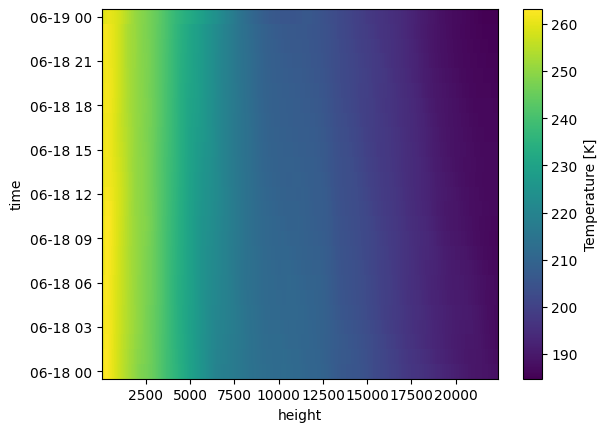

In [215]:
import matplotlib
ds_dash.temperature.plot()

<xarray.Dataset> Size: 69kB
Dimensions:      (time: 25, level: 137)
Coordinates:
    height       (time, level) float32 14kB 8.634 26.77 ... 6.931e+04 7.413e+04
  * time         (time) datetime64[ns] 200B 2023-06-18 ... 2023-06-19
  * level        (level) int16 274B 137 136 135 134 133 132 131 ... 6 5 4 3 2 1
Data variables:
    temperature  (time, level) float32 14kB 248.8 249.9 252.7 ... 227.7 217.3
    pressure     (time, level) float32 14kB 9.883e+04 9.86e+04 ... 3.102 2.0
    rh           (time, level) float32 14kB 0.7718 0.684 ... 0.0 1.461e-07
    q            (time, level) float32 14kB 0.0003288 0.0003239 ... 1.317e-06
Attributes:
    source:               ECMWF Integrated Forecast System (IFS)
    institution:          European Centre for Medium-Range Weather Forecasting
    initialization_time:  2023-06-18 00:00:00 +00:00
    Conventions:          CF-1.8
    title:                ECMWF IFS single-site output over Neumayer III
    location:             Neumayer III
    file_uuid:            7df280a3-bc0c-4ae6-8df6-ff0bfc201570
    cloudnet_file_type:   model
    year:                 2023
    month:                06
    day:                  18
    history:              2023-06-19 05:03:30 +00:00 - model metadata harmoni...

(-100.0, 1000.0)

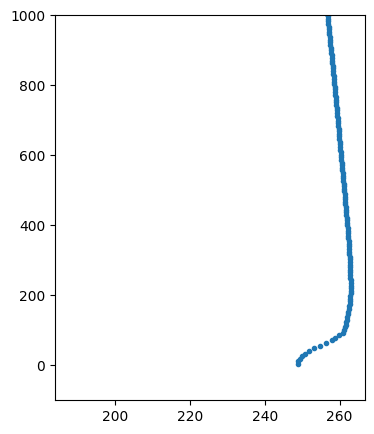

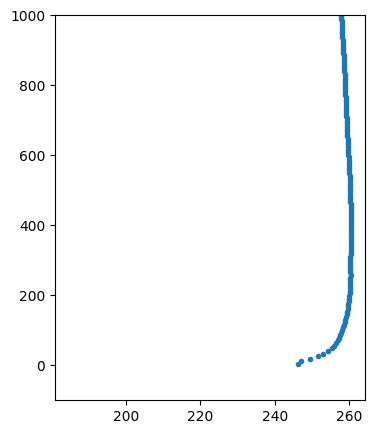

In [218]:
fig, ax = plt.subplots(figsize=(4,5))


ax.plot(ds_dash.isel(time=0)['temperature'], ds_dash.height, '.')

ax.set_ylim(-100, 1000)

fig, ax = plt.subplots(figsize=(4,5))

ax.plot(ds_dash.isel(time=-1)['temperature'], ds_dash.height, '.')

ax.set_ylim(-100, 1000)

(-100.0, 1000.0)

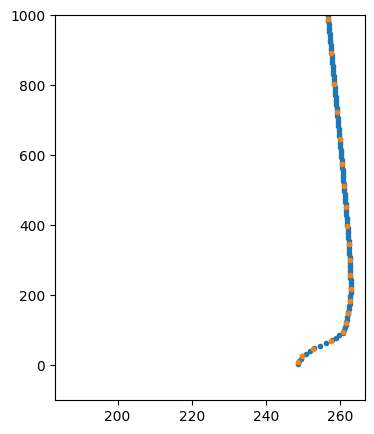

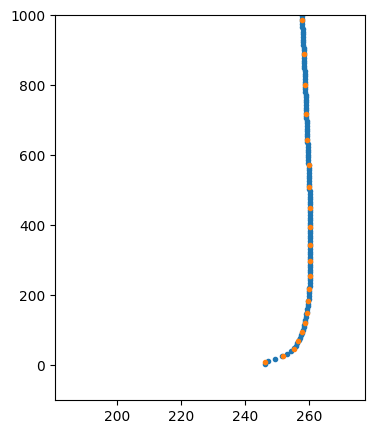

In [198]:
fig, ax = plt.subplots(figsize=(4,5))

ax.plot(ds_new.isel(time=0)['temperature'], ds_new.height, '.')
ax.plot(ds_dash.isel(time=0)['temperature'], ds_dash.height.isel(time=0), '.')

ax.set_ylim(-100, 1000)

fig, ax = plt.subplots(figsize=(4,5))

ax.plot(ds_new.isel(time=-1)['temperature'], ds_new.height, '.')
ax.plot(ds_dash.isel(time=-1)['temperature'], ds_dash.height.isel(time=-1), '.')

ax.set_ylim(-100, 1000)